In [1]:
import os
import subprocess
import logging
from google.cloud import bigquery, storage
import google.auth
 
import requests
import json
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import time

from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
 
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
 
#nuevo
# Make clients.
bqclient = bigquery.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))
bqstorageclient = storage.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))

## Preprocesamiento y limpieza de datos

### tabla altas (electricidad)

In [2]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.altas_con_id`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
df_altas = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
df_altas


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.altas_con_id`



,fecha,signup_date_altas,dwh_customer_key,customer_id,product,canal
0,2025-03-01,2025-02-27,46429516,47748986,Electricidad,CANCELACIONES
1,2025-02-18,2025-02-16,46429516,47748986,Electricidad,DIGITAL
2,2025-02-27,NaT,46429516,47748986,Electricidad,CANCELACIONES
3,2025-02-16,NaT,46429516,47748986,Electricidad,DIGITAL
4,2025-02-24,NaT,42750901,37935813,Electricidad,CARTERA OUTBOUND
...,...,...,...,...,...,...
12265,2025-02-06,NaT,46260327,30540500,Gas,DIGITAL
12266,2025-02-21,NaT,46749867,22568672,Electricidad,TIENDAS
12267,2025-02-25,2025-02-21,46749867,22568672,Electricidad,TIENDAS
12268,2025-02-19,2025-02-14,54381416,25412984,Electricidad,DIGITAL


In [3]:
df_altas['product'].unique()

array(['Electricidad', 'SVE', 'SVG', 'Gas'], dtype=object)

In [4]:
df_altas['canal'].unique()

array(['CANCELACIONES', 'DIGITAL', 'CARTERA OUTBOUND', 'STANDS',
       'SERVICES2SALES', 'OTROS', 'TIENDAS', 'CUSTOMER CARE', None],
      dtype=object)

In [5]:
#transformar ese df a solo Electricidad
df_altas_electricidad = df_altas[df_altas["product"]=="Electricidad"]

In [6]:
df_altas_electricidad = pl.from_pandas(df_altas_electricidad)
df_altas_electricidad

fecha,signup_date_altas,dwh_customer_key,customer_id,product,canal
date,date,i64,i64,str,str
2025-03-01,2025-02-27,46429516,47748986,"""Electricidad""","""CANCELACIONES"""
2025-02-18,2025-02-16,46429516,47748986,"""Electricidad""","""DIGITAL"""
2025-02-27,null,46429516,47748986,"""Electricidad""","""CANCELACIONES"""
2025-02-16,null,46429516,47748986,"""Electricidad""","""DIGITAL"""
2025-02-24,null,42750901,37935813,"""Electricidad""","""CARTERA OUTBOUND"""
…,…,…,…,…,…
2025-03-22,2025-03-19,47161463,20897640,"""Electricidad""","""DIGITAL"""
2025-02-21,null,46749867,22568672,"""Electricidad""","""TIENDAS"""
2025-02-25,2025-02-21,46749867,22568672,"""Electricidad""","""TIENDAS"""


### tabla de nptb

In [7]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
df_nptb = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
df_nptb.rename(columns={"uni_id_cliente": "id_cliente"}, inplace=True)
df_nptb = pl.from_pandas(df_nptb)


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz`



In [8]:
df_nptb.shape

(4110045, 209)

### tabla churn

In [9]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
df_churn = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
df_churn.rename(columns={"customer_id": "id_cliente"}, inplace=True)
df_churn = pl.from_pandas(df_churn)


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz`



### correlacion de variables comunes entre churn y nptb

In [10]:
# Encontrar columnas en común
columnas_comunes = list(set(df_nptb.columns) & set(df_churn.columns))

# Crear un nuevo DataFrame con solo las columnas comunes
df_comun_nptb = df_nptb.select(columnas_comunes)
df_comun_churn = df_churn.select(columnas_comunes)
# df_comun1.describe()

In [11]:
# cuantos valores diferentes hay por cada variable de churn
print("VALORES UNICOS EN NPTB")
print(f'churn crm_eventos_in_sum_pond_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_sum_pond_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_min_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_min_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_prob_cond_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_prob_cond_avg_sdb_30d"].unique())}')
print(f'churn ndt_data_date: {len(df_comun_nptb["ndt_data_date"].unique())}')
print(f'churn crm_eventos_in_max_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_max_avg_sdb_30d"].unique())}')

VALORES UNICOS EN NPTB
churn crm_eventos_in_sum_pond_avg_sdb_30d: 352431
churn crm_eventos_in_min_avg_sdb_30d: 1155
churn crm_eventos_in_prob_cond_avg_sdb_30d: 214254
churn ndt_data_date: 3
churn crm_eventos_in_max_avg_sdb_30d: 1157


In [12]:
# cuantos valores diferentes hay por cada variable de churn
print("VALORES UNICOS EN CHURN")
print(f'churn crm_eventos_in_sum_pond_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_sum_pond_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_min_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_min_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_prob_cond_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_prob_cond_avg_sdb_30d"].unique())}')
print(f'churn ndt_data_date: {len(df_comun_churn["ndt_data_date"].unique())}')
print(f'churn crm_eventos_in_max_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_max_avg_sdb_30d"].unique())}')

VALORES UNICOS EN CHURN
churn crm_eventos_in_sum_pond_avg_sdb_30d: 386269
churn crm_eventos_in_min_avg_sdb_30d: 1157
churn crm_eventos_in_prob_cond_avg_sdb_30d: 237250
churn ndt_data_date: 3
churn crm_eventos_in_max_avg_sdb_30d: 1157


/var/tmp/ipykernel_2740823/1295193818.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_merged_corr.to_pandas().corr()


shape: (4110039, 11)


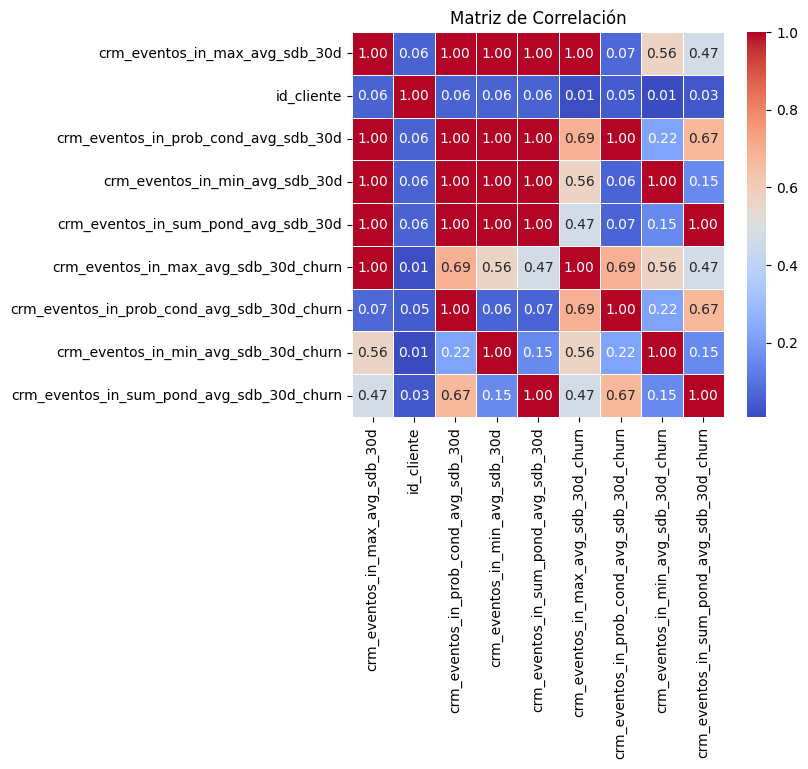

In [13]:
df_merged_corr = df_comun_nptb.join(df_comun_churn, on="id_cliente", how="inner", suffix="_churn")

# esto es para que se quede solo para quedarte solo las que coincidan por fecha (si no, hace un producto cartesiano de fechas)
df_merged_corr = df_merged_corr.filter(df_merged_corr["ndt_data_date"] == df_merged_corr["ndt_data_date_churn"])

# Convertir a Pandas para calcular la matriz de correlación
df_corr = df_merged_corr.to_pandas().corr()

print(f"shape: {df_merged_corr.shape}")

# Graficar la matriz de correlación con matplotlib y seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

De aquí sacamos 2 conclusiones:
- Las columnas de **churn** tienen los mismos valores que las de **nptb**
- Dentro de **nptb**, como hay columnas con valores iguales, las dropeamos porque no aportan información y nos quedamos solo con una de ellas. Nos quedamos con *crm_eventos_in_sum_pond_avg_sdb_30d*

>no entiendo muy bien como se pueden dar casos como: <br>
>**crm_eventos_in_sum_pond_avg_sdb_30d** con **crm_eventos_in_sum_pond_avg_sdb_30d_churn** sea 1
>**crm_eventos_in_sum_pond_avg_sdb_30d** con **crm_eventos_in_prob_cond_avg_sdb_30d** sea 1 <br>
>PERO **crm_eventos_in_prob_cond_avg_sdb_30d** con **crm_eventos_in_sum_pond_avg_sdb_30d_churn** no sea 1... <br>
>lo achaco a que hay NaNs (?)

### JOIN nptb x churn
Quitando las columnas con información redundante

In [14]:
# df_cruce = df_nptb.join(df_churn, on="id_cliente", how="inner", suffix="_churn")
# df_cruce = df_cruce.filter(df_cruce["ndt_data_date"] == df_cruce["ndt_data_date_churn"])
# df_cruce = df_cruce.drop(["ndt_data_date_churn"])

consulta_join = """
select nptb.*, churn.* from `mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz` as nptb
join `mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz` as churn
on  nptb.uni_id_cliente = churn.customer_id and nptb.ndt_data_date=churn.ndt_data_date
"""
df_join = (
    bqclient.query(consulta_join)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
df_join.rename(columns={"uni_id_cliente": "id_cliente"}, inplace=True)
df_join = pl.from_pandas(df_join)
df_join = df_join.drop(["crm_eventos_in_sum_pond_avg_sdb_30d", 
                        "crm_eventos_in_prob_cond_avg_sdb_30d", 
                        "crm_eventos_in_min_avg_sdb_30d", 
                        "ndt_data_date_1",
                        "event_timestamp",
                        "created_timestamp"
                       ])

# cambiar las fechas a AÑOMES
df_join = df_join.with_columns(
    pl.col("ndt_data_date").str.slice(0, 6).alias("ndt_data_date")
)


print(f"total shape: {df_join.shape}")

df_join.head(10)

total shape: (4110039, 373)


id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,uni_min_cp_importe_fin_linea,uni_min_cp_dias_fin_linea,uni_comp_lineas_oo,…,oe_alarm_ont_fij_cli_dm7,num_llamadas_in_high_dm30,total_duracion_in_high_dm30,maxima_duracion_in_high_dm30,dias_desde_ultima_llamada_in_high,num_contactos_distintos_in_high_dm30,num_llamadas_in_medium_dm30,total_duracion_in_medium_dm30,maxima_duracion_in_medium_dm30,dias_desde_ultima_llamada_in_medium,num_contactos_distintos_in_medium_dm30,num_llamadas_in_low_dm30,total_duracion_in_low_dm30,maxima_duracion_in_low_dm30,dias_desde_ultima_llamada_in_low,num_contactos_distintos_in_low_dm30,num_llamadas_out_high_dm30,total_duracion_out_high_dm30,maxima_duracion_out_high_dm30,dias_desde_ultima_llamada_out_high,num_contactos_distintos_out_high_dm30,num_llamadas_out_medium_dm30,total_duracion_out_medium_dm30,maxima_duracion_out_medium_dm30,dias_desde_ultima_llamada_out_medium,num_contactos_distintos_out_medium_dm30,num_llamadas_out_low_dm30,total_duracion_out_low_dm30,maxima_duracion_out_low_dm30,dias_desde_ultima_llamada_out_low,num_contactos_distintos_out_low_dm30,num_sms_in_high_dm30,dias_desde_ultimo_sms_in_high,num_contactos_distintos_sms_in_high_dm30,num_sms_in_medium_dm30,dias_desde_ultimo_sms_in_medium,num_contactos_distintos_sms_in_medium_dm30
i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
37466673,1,1,0,"""RESIDENCIAL""",1,1,63,27,63,30,0.0,0.0,-1565,0.0,0,0,0,98,0,0,0,0,8,22.73,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,0,…,2,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
38854932,1,1,0,"""RESIDENCIAL""",1,1,54,29,60,28,0.0,0.0,-1477,0.0,0,0,0,6901,0,0,0,0,55,119.57,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,1,…,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
50251069,1,0,0,"""RESIDENCIAL""",1,0,19,19,19,28,0.0,0.0,-216,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,0.0,-216,1,…,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
49350949,1,1,0,"""RESIDENCIAL""",1,3,23,4,23,36,661.584106,0.51,599,0.82,8,0,15,765,0,0,0,0,69,84.980003,0,0.0,0.0,1000,0,0,0,0,0,133.104599,228,0,…,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
41897997,1,0,0,"""RESIDENCIAL""",1,0,31,31,50,29,0.0,0.0,-1279,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,0.0,-1279,1,…,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
20759074,1,1,0,"""RESIDENCIAL""",1,1,125,40,173,34,0.0,0.0,-2149,0.0,0,0,0,33,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,0.0,-2502,0,…,2,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
26204937,0,1,0,"""GRAN CUENTA""",0,2,125,98,132,177,0.0,0.0,-2802,0.0,0,0,0,1029,0,0,0,0,488,1220.449951,0,0.0,0.0,1000,0,0,60,112,0,0.0,-9999,6,…,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0
49882374,1,1,0,"""RESIDENCIAL""",2,3,22,11,22,72,0.0

### Ponemos un target

In [15]:
# limpiamos el df de altas (electricidad) de campos que no nos interesan
df_altas_electricidad = df_altas_electricidad.drop(["signup_date_altas", "product", "canal","dwh_customer_key"])

In [16]:
df_altas_electricidad = (df_altas_electricidad
                         # .filter(pl.col("dwh_customer_key").str.contains(r"^\d+$")) # se evitan las filas con campos UUID (solo son 17)
                         .with_columns(pl.col("customer_id").cast(pl.Int64) # se pasa la id a int
                                      )
                        )

df_altas_electricidad = df_altas_electricidad.with_columns(
    pl.col("fecha").dt.strftime("%Y%m").alias("fecha") # se pasa la fecha al mismo formato que en la tabla join
)

# ponemos el mismo nombre a las columnas para hacer el join
df_altas_electricidad = df_altas_electricidad.rename({"fecha": "ndt_data_date", "customer_id": "id_cliente"})

df_altas_electricidad.head(5)

ndt_data_date,id_cliente
str,i64
"""202503""",47748986
"""202502""",47748986
"""202502""",47748986
"""202502""",47748986
"""202502""",37935813


In [17]:
df_altas_electricidad.shape

(8272, 2)

In [18]:
# agrega columna target = 0 en df
df_join = df_join.with_columns(pl.lit(0).alias("target"))

# realiza un join para marcar coincidencias
df_join = df_join.join(
    df_altas_electricidad.with_columns(pl.lit(1).alias("marca")),  # añade columna auxiliar
    on=["ndt_data_date", "id_cliente"],
    how="left"
)

# si hay coincidencia (marca == 1), pon target = 1, si no, deja 0
df_join = df_join.with_columns(
    pl.when(pl.col("marca") == 1).then(1).otherwise(pl.col("target")).alias("target")
)

# elimina la columna auxiliar
df_join = df_join.drop("marca")

In [19]:
df_join.head(10)

id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,uni_min_cp_importe_fin_linea,uni_min_cp_dias_fin_linea,uni_comp_lineas_oo,…,num_llamadas_in_high_dm30,total_duracion_in_high_dm30,maxima_duracion_in_high_dm30,dias_desde_ultima_llamada_in_high,num_contactos_distintos_in_high_dm30,num_llamadas_in_medium_dm30,total_duracion_in_medium_dm30,maxima_duracion_in_medium_dm30,dias_desde_ultima_llamada_in_medium,num_contactos_distintos_in_medium_dm30,num_llamadas_in_low_dm30,total_duracion_in_low_dm30,maxima_duracion_in_low_dm30,dias_desde_ultima_llamada_in_low,num_contactos_distintos_in_low_dm30,num_llamadas_out_high_dm30,total_duracion_out_high_dm30,maxima_duracion_out_high_dm30,dias_desde_ultima_llamada_out_high,num_contactos_distintos_out_high_dm30,num_llamadas_out_medium_dm30,total_duracion_out_medium_dm30,maxima_duracion_out_medium_dm30,dias_desde_ultima_llamada_out_medium,num_contactos_distintos_out_medium_dm30,num_llamadas_out_low_dm30,total_duracion_out_low_dm30,maxima_duracion_out_low_dm30,dias_desde_ultima_llamada_out_low,num_contactos_distintos_out_low_dm30,num_sms_in_high_dm30,dias_desde_ultimo_sms_in_high,num_contactos_distintos_sms_in_high_dm30,num_sms_in_medium_dm30,dias_desde_ultimo_sms_in_medium,num_contactos_distintos_sms_in_medium_dm30,target
i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32
37466673,1,1,0,"""RESIDENCIAL""",1,1,63,27,63,30,0.0,0.0,-1565,0.0,0,0,0,98,0,0,0,0,8,22.73,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,0,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
38854932,1,1,0,"""RESIDENCIAL""",1,1,54,29,60,28,0.0,0.0,-1477,0.0,0,0,0,6901,0,0,0,0,55,119.57,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,1,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
50251069,1,0,0,"""RESIDENCIAL""",1,0,19,19,19,28,0.0,0.0,-216,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,0.0,-216,1,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
49350949,1,1,0,"""RESIDENCIAL""",1,3,23,4,23,36,661.584106,0.51,599,0.82,8,0,15,765,0,0,0,0,69,84.980003,0,0.0,0.0,1000,0,0,0,0,0,133.104599,228,0,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
41897997,1,0,0,"""RESIDENCIAL""",1,0,31,31,50,29,0.0,0.0,-1279,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,0.0,-1279,1,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
20759074,1,1,0,"""RESIDENCIAL""",1,1,125,40,173,34,0.0,0.0,-2149,0.0,0,0,0,33,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,0.0,-2502,0,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
26204937,0,1,0,"""GRAN CUENTA""",0,2,125,98,132,177,0.0,0.0,-2802,0.0,0,0,0,1029,0,0,0,0,488,1220.449951,0,0.0,0.0,1000,0,0,60,112,0,0.0,-9999,6,…,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0
49882374,1,1,0,"""RESIDENCIAL""",2,3,22,11,22,72,0.0,0.0,-314,0.0,0,0,

### Tratamiento de las fechas, con valores enteros proporcionales a la antigüedad

In [20]:
# 1. Obtener valores únicos y ordenarlos
fechas_ordenadas = sorted(df_join["ndt_data_date"].unique().to_list())

# 2. Crear un DataFrame de mapeo
df_mapeo = pl.DataFrame({
    "ndt_data_date": fechas_ordenadas,
    "ndt_data_date_int": list(range(1, len(fechas_ordenadas) + 1))
})

# 3. Join para incorporar la columna numérica
df_join = df_join.join(df_mapeo, on="ndt_data_date", how="left")

df_join["ndt_data_date"].head(10)

ndt_data_date
str
"""202501"""
"""202503"""
"""202501"""
"""202503"""
"""202502"""
"""202503"""
"""202502"""
"""202502"""
"""202501"""


### borramos campos sobrantes (id_cliente y el campo string de ndt_data_date

In [21]:
# borramos la columna fecha que sobra y también la de id, que no aportará información para la predicción
df_join = df_join.drop(["ndt_data_date", "id_cliente", "customer_id"]).rename({"ndt_data_date_int": "ndt_data_date"})

### Tratamiento de columnas con valores categóricos y fechas

Vemos los valores categóricos de los campos que son string

In [22]:
columnas_str = [col for col in df_join.columns if df_join[col].dtype == pl.Utf8]
for c in columnas_str:
    print(df_join[c].unique())

shape: (5,)
Series: 'uni_cliente_segmento' [str]
[
	"PYME"
	"RESIDENCIAL"
	"GRAN CUENTA"
	"PROFESIONAL"
	"ISP"
]
shape: (14,)
Series: 'axe_tipofamilia' [str]
[
	"Parejas Jovenes DINKIS"
	""
	"Familia Estandar Joven"
	"Singles"
	"Familia Monoparentales con Hij…
	…
	"Resto"
	"Parejas Jubiladas"
	null
	"Viudos"
	"Parejas Senior Sin Hijos"
]
shape: (7,)
Series: 'axe_nucleo' [str]
[
	"Pareja"
	""
	"Compartidos / Otros/ Mix"
	"Monoparental"
	"Familiares"
	"Single"
	null
]
shape: (6,)
Series: 'axe_perfilnucleo' [str]
[
	"Joven"
	"Jubilado "
	null
	""
	"Senior"
	"Adulto"
]
shape: (6,)
Series: 'axe_perfilhijos' [str]
[
	"No Emancipados"
	"Menores"
	"Jovenes"
	"Sin Hijos"
	null
	""
]
shape: (5,)
Series: 'cliente_segmento' [str]
[
	"PYME"
	"PROFESIONAL"
	"ISP"
	"GRAN CUENTA"
	"RESIDENCIAL"
]


Ahora que todas las columnas string son categóricas, aplicamos el **to_dummies** para hacer una columna para cada valor con 0 o 1. (one-hot-encoding)

In [23]:
columnas_str = [col for col in df_join.columns if df_join[col].dtype == pl.Utf8]

# Aplica to_dummies() sobre esas columnas
df_join = df_join.to_dummies(columns=columnas_str)
print("nuevo shape:",df_join.shape)
print("tipos de valores del df:",set(df_join.schema.values()))
df_join.head(10)


nuevo shape: (4113605, 409)
tipos de valores del df: {Int64, UInt8, Int32, Float64}


uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento_GRAN CUENTA,uni_cliente_segmento_ISP,uni_cliente_segmento_PROFESIONAL,uni_cliente_segmento_PYME,uni_cliente_segmento_RESIDENCIAL,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,…,total_duracion_in_high_dm30,maxima_duracion_in_high_dm30,dias_desde_ultima_llamada_in_high,num_contactos_distintos_in_high_dm30,num_llamadas_in_medium_dm30,total_duracion_in_medium_dm30,maxima_duracion_in_medium_dm30,dias_desde_ultima_llamada_in_medium,num_contactos_distintos_in_medium_dm30,num_llamadas_in_low_dm30,total_duracion_in_low_dm30,maxima_duracion_in_low_dm30,dias_desde_ultima_llamada_in_low,num_contactos_distintos_in_low_dm30,num_llamadas_out_high_dm30,total_duracion_out_high_dm30,maxima_duracion_out_high_dm30,dias_desde_ultima_llamada_out_high,num_contactos_distintos_out_high_dm30,num_llamadas_out_medium_dm30,total_duracion_out_medium_dm30,maxima_duracion_out_medium_dm30,dias_desde_ultima_llamada_out_medium,num_contactos_distintos_out_medium_dm30,num_llamadas_out_low_dm30,total_duracion_out_low_dm30,maxima_duracion_out_low_dm30,dias_desde_ultima_llamada_out_low,num_contactos_distintos_out_low_dm30,num_sms_in_high_dm30,dias_desde_ultimo_sms_in_high,num_contactos_distintos_sms_in_high_dm30,num_sms_in_medium_dm30,dias_desde_ultimo_sms_in_medium,num_contactos_distintos_sms_in_medium_dm30,target,ndt_data_date
i64,i64,i64,u8,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i64
1,1,0,0,0,0,0,1,1,1,63,27,63,30,0.0,0.0,-1565,0.0,0,0,0,98,0,0,0,0,8,22.73,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,1
1,1,0,0,0,0,0,1,1,1,54,29,60,28,0.0,0.0,-1477,0.0,0,0,0,6901,0,0,0,0,55,119.57,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
1,0,0,0,0,0,0,1,1,0,19,19,19,28,0.0,0.0,-216,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,1
1,1,0,0,0,0,0,1,1,3,23,4,23,36,661.584106,0.51,599,0.82,8,0,15,765,0,0,0,0,69,84.980003,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
1,0,0,0,0,0,0,1,1,0,31,31,50,29,0.0,0.0,-1279,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,1,1,125,40,173,34,0.0,0.0,-2149,0.0,0,0,0,33,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
0,1,0,1,0,0,0,0,0,2,125,98,132,177,0.0,0.0,-2802,0.0,0,0,0,1029,0,0,0,0,488,1220.449951,0,0.0,0.0,1000,0,0,60,112,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,2,3,22,11,22,72,0.0,0.0,-314,0.0,0,0,0,34715,0,0,0,0,206,541.929993,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,1,1,49,9,49,49,1470.89917

Ahora solo tenemos valores tabulares en el dataframe.

### Visionado del dataframe final

In [24]:
df_join.columns

['uni_cliente_fijo',
 'uni_cliente_movil',
 'uni_cliente_tv',
 'uni_cliente_segmento_GRAN CUENTA',
 'uni_cliente_segmento_ISP',
 'uni_cliente_segmento_PROFESIONAL',
 'uni_cliente_segmento_PYME',
 'uni_cliente_segmento_RESIDENCIAL',
 'uni_lineas_fijo_cliente',
 'uni_lineas_movil_cliente',
 'uni_antig_linea_max',
 'uni_antig_linea_min',
 'uni_antig_cliente',
 'uni_arpu_medio_4m',
 'uni_cp_importe_fin_cli',
 'uni_cp_importe_pctpend_cli',
 'uni_cp_dias_fin_cli',
 'uni_cp_dias_pctpend_cli',
 'uni_dto_meses_fin_cli',
 'uni_dto_valor_cli',
 'uni_dto_porc_cli',
 'uni_mb_consumo_movil_cli',
 'uni_bono_100_mb_cli',
 'uni_bono_adicional_mb_cli',
 'uni_bono_mas_mb_cli',
 'uni_bono_cesion_mb_cli',
 'uni_num_llamadas_dentro_tarifa_cli',
 'uni_minutos_dentro_tarifa_cli',
 'uni_num_llamadas_fuera_tarifa_cli',
 'uni_minutos_fuera_tarifa_cli',
 'uni_importe_fuera_tarifa_cli',
 'uni_dias_consulta_cp',
 'uni_ppfide_dm7',
 'uni_flag_deposito_mb',
 'uni_meses_usdb_movil',
 'uni_meses_1sdb_movil',
 'uni_line

In [25]:
# vistazo final del DF resultante
print("tipos:",set(df_join.schema.values()))
print("shape:",df_join.shape)
df_join.head(10)

tipos: {Int64, UInt8, Int32, Float64}
shape: (4113605, 409)


uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento_GRAN CUENTA,uni_cliente_segmento_ISP,uni_cliente_segmento_PROFESIONAL,uni_cliente_segmento_PYME,uni_cliente_segmento_RESIDENCIAL,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,…,total_duracion_in_high_dm30,maxima_duracion_in_high_dm30,dias_desde_ultima_llamada_in_high,num_contactos_distintos_in_high_dm30,num_llamadas_in_medium_dm30,total_duracion_in_medium_dm30,maxima_duracion_in_medium_dm30,dias_desde_ultima_llamada_in_medium,num_contactos_distintos_in_medium_dm30,num_llamadas_in_low_dm30,total_duracion_in_low_dm30,maxima_duracion_in_low_dm30,dias_desde_ultima_llamada_in_low,num_contactos_distintos_in_low_dm30,num_llamadas_out_high_dm30,total_duracion_out_high_dm30,maxima_duracion_out_high_dm30,dias_desde_ultima_llamada_out_high,num_contactos_distintos_out_high_dm30,num_llamadas_out_medium_dm30,total_duracion_out_medium_dm30,maxima_duracion_out_medium_dm30,dias_desde_ultima_llamada_out_medium,num_contactos_distintos_out_medium_dm30,num_llamadas_out_low_dm30,total_duracion_out_low_dm30,maxima_duracion_out_low_dm30,dias_desde_ultima_llamada_out_low,num_contactos_distintos_out_low_dm30,num_sms_in_high_dm30,dias_desde_ultimo_sms_in_high,num_contactos_distintos_sms_in_high_dm30,num_sms_in_medium_dm30,dias_desde_ultimo_sms_in_medium,num_contactos_distintos_sms_in_medium_dm30,target,ndt_data_date
i64,i64,i64,u8,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i64
1,1,0,0,0,0,0,1,1,1,63,27,63,30,0.0,0.0,-1565,0.0,0,0,0,98,0,0,0,0,8,22.73,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,1
1,1,0,0,0,0,0,1,1,1,54,29,60,28,0.0,0.0,-1477,0.0,0,0,0,6901,0,0,0,0,55,119.57,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
1,0,0,0,0,0,0,1,1,0,19,19,19,28,0.0,0.0,-216,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,1
1,1,0,0,0,0,0,1,1,3,23,4,23,36,661.584106,0.51,599,0.82,8,0,15,765,0,0,0,0,69,84.980003,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
1,0,0,0,0,0,0,1,1,0,31,31,50,29,0.0,0.0,-1279,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,1,1,125,40,173,34,0.0,0.0,-2149,0.0,0,0,0,33,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,3
0,1,0,1,0,0,0,0,0,2,125,98,132,177,0.0,0.0,-2802,0.0,0,0,0,1029,0,0,0,0,488,1220.449951,0,0.0,0.0,1000,0,0,60,112,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,2,3,22,11,22,72,0.0,0.0,-314,0.0,0,0,0,34715,0,0,0,0,206,541.929993,0,0.0,0.0,1000,0,0,0,0,0,…,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,0,2
1,1,0,0,0,0,0,1,1,1,49,9,49,49,1470.89917

## Construcción del dataset de entrenamiento y prueba del modelo

In [26]:
# Separa X (variables) e y (target)
X = df_join.drop("target")
y = df_join["target"]

In [27]:
y.to_frame().filter(pl.col("target") == 1).shape

(7399, 1)

In [28]:
# Separar clases
df_positivos = df_join.filter(pl.col("target") == 1)  # Todos los positivos (7k filas)
df_negativos = df_join.filter(pl.col("target") == 0)  # Todos los negativos (millones)

# Hacer undersampling de negativos para igualar el número de positivos
df_negativos_sample = df_negativos.sample(n=df_positivos.height*50, seed=42)

# Combinar ambos conjuntos
df_sec = pl.concat([df_positivos, df_negativos_sample])

print(df_sec.shape)  # Debería tener ~318 filas (159 + 159)


(377349, 409)


In [29]:
X_sec = df_sec.drop("target")
y_sec = df_sec["target"]

In [30]:
modelo = XGBClassifier(n_estimators=200, random_state=42)
modelo.fit(X_sec, y_sec)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [31]:
# Suponiendo que ya tienes un modelo entrenado llamado `modelo`
importancias = modelo.feature_importances_

# Crear un DataFrame ordenado con los nombres de las características
df_importancia = pd.DataFrame({
    "caracteristica": X_sec.columns,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False)

# Mostrar el top 10
print(df_importancia.head(15))


                             caracteristica  importancia
407                           ndt_data_date     0.058014
393         maxima_duracion_out_medium_dm30     0.039550
40                               uni_riesgo     0.016079
16                      uni_cp_dias_fin_cli     0.012025
63     uni_ratio_consumo_contratado_minutos     0.010310
394    dias_desde_ultima_llamada_out_medium     0.009946
184    trf_nro_lineas_mov_con_tarifa_no_top     0.008374
8                   uni_lineas_fijo_cliente     0.007839
66                    uni_dias_ult_rfb_disp     0.007703
286  crm_whatsapp_num_events_dm45_churn_010     0.006977
47              uni_flag_contactos_linea_1m     0.006724
49             uni_smartphones_alta_premium     0.006674
5          uni_cliente_segmento_PROFESIONAL     0.006169
21                 uni_mb_consumo_movil_cli     0.006143
17                  uni_cp_dias_pctpend_cli     0.005415


## Iteraciones

In [32]:
# función para imprimir las métricas ROC AUC y LIFT
def evaluar_modelo(y_true, y_pred_proba, top_percentiles=[1, 5, 10]):
    """
    Calcula ROC AUC y LIFT en los percentiles indicados (por defecto 1%, 5%, 10%).
    
    Args:
        y_true: array-like, etiquetas reales (0 o 1) -el target-
        y_pred_proba: array-like, probabilidades predichas para la clase positiva
        top_percentiles: lista de percentiles a evaluar para el Lift

    Returns:
        None (imprime las métricas)
    """
    # Crear DataFrame ordenado por score
    df = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_pred_proba
    }).sort_values(by="y_score", ascending=False).reset_index(drop=True)

    # ROC AUC
    auc = roc_auc_score(df["y_true"], df["y_score"])
    print(f"\tROC AUC: {auc:.4f}")

    # Tasa base (porcentaje de positivos en todo el dataset)
    tasa_base = df["y_true"].mean()
    
    lifts = {}
    # Calcular Lift en cada top X%
    for p in top_percentiles:
        corte = int(len(df) * p / 100)
        top_df = df.iloc[:corte]
        tasa_top = top_df["y_true"].mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0
        lifts[p]=lift
        print(f"\tLift @ top {p}%: {lift:.2f}x")
    return auc, lifts



### Iteraciones con umbral de 0.01

In [33]:
# division en train y test
X_train, X_val, y_train, y_val = train_test_split(X_sec.clone(), y_sec.clone(), test_size=0.2, random_state=42)

In [34]:
UMBRAL = 0.01
LIFT_PERCENTILES=[1, 5, 10]

mejor_auc = -1
metrics_hist=[]
variables_borradas=[]

while(X_train.shape[1]>1):
    print("-- Entrenamiento con", X_train.shape[1], "variables --")
    modelo = XGBClassifier(n_estimators=200, random_state=42)
    modelo.fit(X_train, y_train)
    
    # MÉTRICAS
    y_pred_proba = modelo.predict_proba(X_val)[:, 1] # esto te devuelve las PROBABILIDADES de que salga un 1 (que están en la pos 1) para cada fila
    auc, lifts = evaluar_modelo(y_val, y_pred_proba, top_percentiles=LIFT_PERCENTILES)
    
    # AÑADIR MÉTRICAS AL HISTORIAL
    metric_row = {
        "n_features": X_train.shape[1],
        "roc_auc": auc
    }


    for p in LIFT_PERCENTILES: # añadimos lifts
        metric_row[f"lift@{p}%"] = lifts.get(p, None)

    metrics_hist.append(metric_row)
    
    
    # Comparar con el mejor AUC observado
    if mejor_auc == -1:
        mejor_auc = auc  # Primera iteración
    elif auc < mejor_auc - UMBRAL:
        print(f"🔴 AUC cayó por debajo del mejor valor permitido: {auc:.4f} < {mejor_auc - UMBRAL:.4f}")
        break
    else:
        mejor_auc = max(mejor_auc, auc)  # Actualizar si hay una mejora
    
    importancias = modelo.feature_importances_
    df_importancia = pd.DataFrame({
        "caracteristica": X_train.columns,
        "importancia": importancias
    }).sort_values(by="importancia", ascending=True) # la que menor importancia tenga: la primera
    print(f"\tVar menor importancia: {df_importancia['caracteristica'][0]}\t{df_importancia['importancia'][0]}")
    
    X_train=X_train.drop(df_importancia['caracteristica'][0])
    X_val=X_val.drop(df_importancia['caracteristica'][0])
    variables_borradas.append(df_importancia['caracteristica'][0])
    
    
    

-- Entrenamiento con 408 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_fijo	0.0
-- Entrenamiento con 407 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_movil	0.0
-- Entrenamiento con 406 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_tv	0.0
-- Entrenamiento con 405 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_segmento_GRAN CUENTA	0.0
-- Entrenamiento con 404 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_segmento_ISP	0.0
-- Entrenamiento con 403 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var men

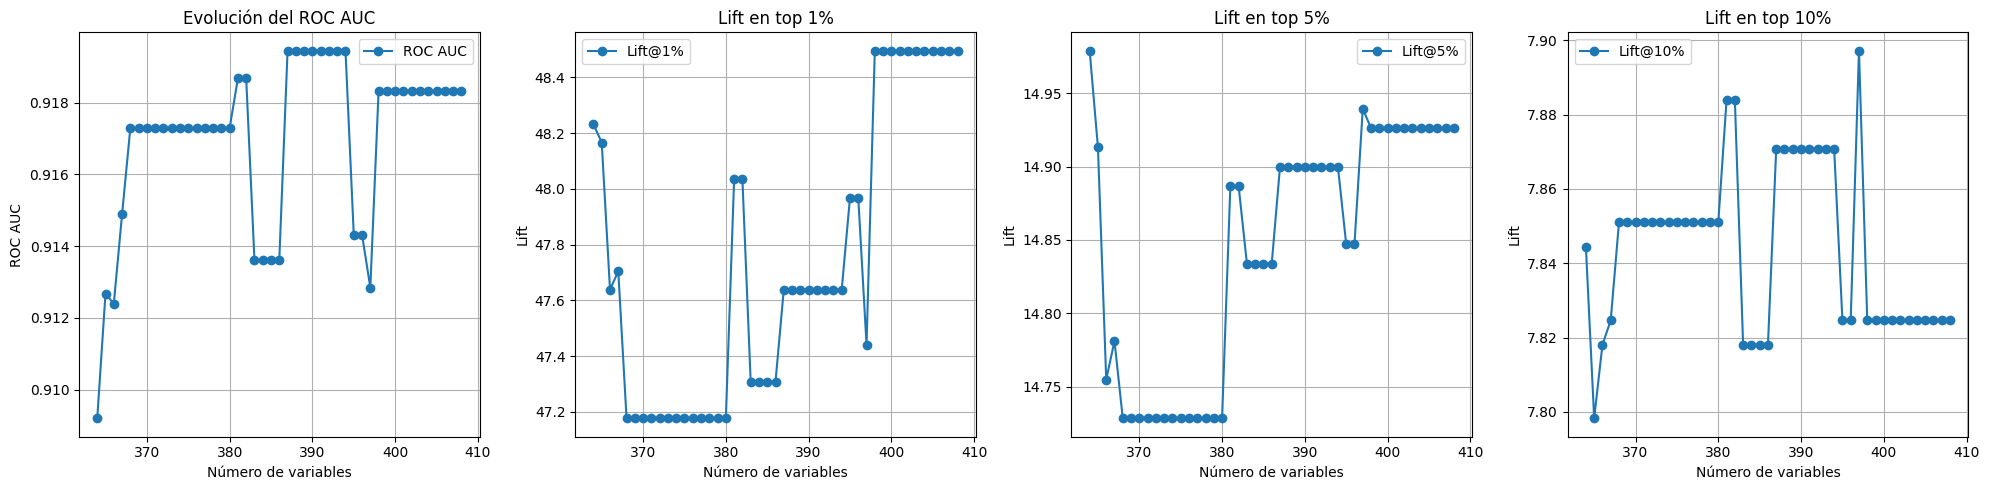

In [35]:
# Convertir métricas a DataFrame
df_metrics = pd.DataFrame(metrics_hist)

# Añadir columna con las variables eliminadas (excepto la última que no se llegó a borrar)
df_metrics["var_eliminada"] = variables_borradas + [None]  # Para igualar longitudes

# Crear figura
fig, axes = plt.subplots(1, len(LIFT_PERCENTILES) + 1, figsize=(5 * (len(LIFT_PERCENTILES) + 1), 5), sharex=True)

# Gráfico 1: ROC AUC
axes[0].plot(df_metrics["n_features"], df_metrics["roc_auc"], marker='o', label="ROC AUC")
axes[0].set_title("Evolución del ROC AUC")
axes[0].set_xlabel("Número de variables")
axes[0].set_ylabel("ROC AUC")
axes[0].invert_xaxis()
axes[0].grid(True)
axes[0].legend()

# Gráficos de LIFT
for i, p in enumerate(LIFT_PERCENTILES):
    axes[i+1].plot(df_metrics["n_features"], df_metrics[f"lift@{p}%"], marker='o', label=f"Lift@{p}%")
    axes[i+1].set_title(f"Lift en top {p}%")
    axes[i+1].set_xlabel("Número de variables")
    axes[i+1].set_ylabel("Lift")
    axes[i+1].invert_xaxis()
    axes[i+1].grid(True)
    axes[i+1].legend()

plt.tight_layout()
plt.show()

### Iteraciones sin umbral

In [36]:
#division en train y test
X_train, X_val, y_train, y_val = train_test_split(X_sec.clone(), y_sec.clone(), test_size=0.2, random_state=42)

In [37]:
# UMBRAL = 0.01
LIFT_PERCENTILES=[1, 5, 10]

# mejor_auc = -1
metrics_hist=[]
variables_borradas=[]

while(X_train.shape[1]>1):
    print("-- Entrenamiento con", X_train.shape[1], "variables --")
    modelo = XGBClassifier(n_estimators=200, random_state=42)
    modelo.fit(X_train, y_train)
    
    # MÉTRICAS
    y_pred_proba = modelo.predict_proba(X_val)[:, 1] # esto te devuelve las PROBABILIDADES de que salga un 1 (que están en la pos 1) para cada fila
    auc, lifts = evaluar_modelo(y_val, y_pred_proba, top_percentiles=LIFT_PERCENTILES)
    
    # AÑADIR MÉTRICAS AL HISTORIAL
    metric_row = {
        "n_features": X_train.shape[1],
        "roc_auc": auc
    }


    for p in LIFT_PERCENTILES: # añadimos lifts
        metric_row[f"lift@{p}%"] = lifts.get(p, None)

    metrics_hist.append(metric_row)
    
    
#     # Comparar con el mejor AUC observado
#     if mejor_auc == -1:
#         mejor_auc = auc  # Primera iteración
#     elif auc < mejor_auc - UMBRAL:
#         print(f"🔴 AUC cayó por debajo del mejor valor permitido: {auc:.4f} < {mejor_auc - UMBRAL:.4f}")
#         break
#     else:
#         mejor_auc = max(mejor_auc, auc)  # Actualizar si hay una mejora
    
    importancias = modelo.feature_importances_
    df_importancia = pd.DataFrame({
        "caracteristica": X_train.columns,
        "importancia": importancias
    }).sort_values(by="importancia", ascending=True) # la que menor importancia tenga: la primera
    print(f"\tVar menor importancia: {df_importancia['caracteristica'][0]}\t{df_importancia['importancia'][0]}")
    
    X_train=X_train.drop(df_importancia['caracteristica'][0])
    X_val=X_val.drop(df_importancia['caracteristica'][0])
    variables_borradas.append(df_importancia['caracteristica'][0])
    
    
    

-- Entrenamiento con 408 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_fijo	0.0
-- Entrenamiento con 407 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_movil	0.0
-- Entrenamiento con 406 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_tv	0.0
-- Entrenamiento con 405 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_segmento_GRAN CUENTA	0.0
-- Entrenamiento con 404 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var menor importancia: uni_cliente_segmento_ISP	0.0
-- Entrenamiento con 403 variables --
	ROC AUC: 0.9183
	Lift @ top 1%: 48.50x
	Lift @ top 5%: 14.93x
	Lift @ top 10%: 7.82x
	Var men

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7f82bb62a500>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
# Convertir métricas a DataFrame
df_metrics = pd.DataFrame(metrics_hist)

# Añadir columna con las variables eliminadas (excepto la última que no se llegó a borrar)
df_metrics["var_eliminada"] = variables_borradas + [None]  # Para igualar longitudes

# Crear figura
fig, axes = plt.subplots(1, len(LIFT_PERCENTILES) + 1, figsize=(5 * (len(LIFT_PERCENTILES) + 1), 5), sharex=True)

# Gráfico 1: ROC AUC
axes[0].plot(df_metrics["n_features"], df_metrics["roc_auc"], marker='o', label="ROC AUC")
axes[0].set_title("Evolución del ROC AUC")
axes[0].set_xlabel("Número de variables")
axes[0].set_ylabel("ROC AUC")
axes[0].invert_xaxis()
axes[0].grid(True)
axes[0].legend()

# Gráficos de LIFT
for i, p in enumerate(LIFT_PERCENTILES):
    axes[i+1].plot(df_metrics["n_features"], df_metrics[f"lift@{p}%"], marker='o', label=f"Lift@{p}%")
    axes[i+1].set_title(f"Lift en top {p}%")
    axes[i+1].set_xlabel("Número de variables")
    axes[i+1].set_ylabel("Lift")
    axes[i+1].invert_xaxis()
    axes[i+1].grid(True)
    axes[i+1].legend()

plt.tight_layout()
plt.show()